In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
DRIVE_PATH = '/content/gdrive/My\ Drive/260final'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
  %mkdir $DRIVE_PATH

## the space in `My Drive` causes some issues,
## make a symlink to avoid this
SYM_PATH = '/content/260final'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

In [3]:
%cd $SYM_PATH

if not os.path.exists("260final"):
    !git clone https://github.com/Dominicliu129/stat260final.git 260final
else:
    print("Already downloaded.")

%cd 260final

/content/gdrive/My Drive/260final
Cloning into '260final'...
fatal: could not read Username for 'https://github.com': No such device or address
[Errno 2] No such file or directory: '260final'
/content/gdrive/My Drive/260final


In [4]:
!pwd

/content/gdrive/My Drive/260final


In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

#Google Trends

In [80]:
df = pd.read_csv('google_trend_ai.csv', skiprows=2)
df['Week'] = pd.to_datetime(df['Week'])

<Axes: xlabel='Week'>

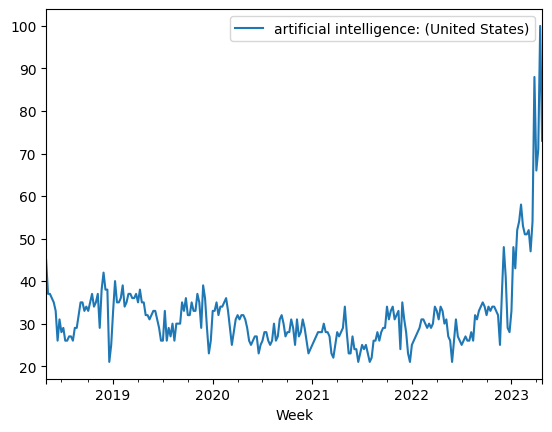

In [81]:
df.plot(x='Week', y='artificial intelligence: (United States)')

In [82]:
#df['numbers'] = range(len(df))
timeseries = df[["artificial intelligence: (United States)"]].values.astype('float32')

In [141]:
train = np.array(timeseries[:-60])
test = np.array(timeseries[-60:])

In [11]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [144]:
lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

In [145]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([196, 4, 1]) torch.Size([196, 4, 1])
torch.Size([56, 4, 1]) torch.Size([56, 4, 1])


In [12]:
class google_trends(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [147]:
model = google_trends()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 500
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 29.8263, test RMSE 40.1082
Epoch 100: train RMSE 3.4689, test RMSE 14.0015
Epoch 200: train RMSE 3.0772, test RMSE 12.6339
Epoch 300: train RMSE 2.9933, test RMSE 12.0685
Epoch 400: train RMSE 2.9422, test RMSE 11.7690


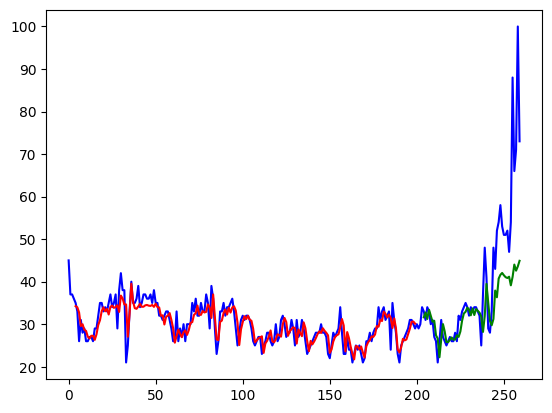

In [150]:
train_size = 200
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

## Rainfall

In [85]:
df = pd.read_csv('CSVDataServlet.txt')

In [86]:
df.columns

Index(['STATION_ID', 'DURATION', 'SENSOR_NUMBER', 'SENSOR_TYPE', 'DATE TIME',
       'OBS DATE', 'VALUE', 'DATA_FLAG', 'UNITS'],
      dtype='object')

In [87]:
df = df.loc[:, ['DATE TIME', 'VALUE']]

In [88]:
df['DATE TIME'] = pd.to_datetime(df['DATE TIME'])

In [89]:
df_grouped = df.groupby(df['DATE TIME'].dt.date)['VALUE'].agg('mean').reset_index()

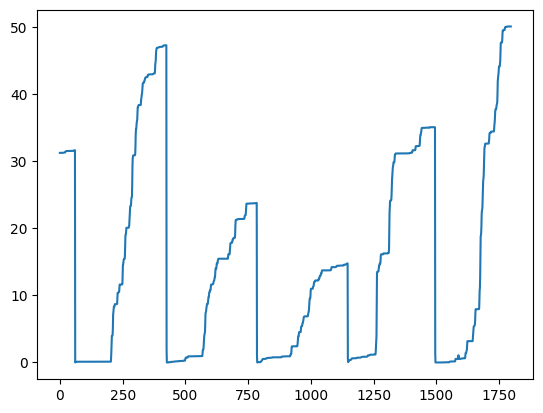

In [91]:
timeseries = df_grouped[['VALUE']].values.astype('float32')
plt.plot(timeseries)
plt.show()

In [92]:
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [93]:
lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

In [97]:
class rainfall(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [98]:
model = rainfall()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 500
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 14.0404, test RMSE 20.1921
Epoch 100: train RMSE 1.7805, test RMSE 1.6080
Epoch 200: train RMSE 1.7798, test RMSE 1.6697
Epoch 300: train RMSE 1.7747, test RMSE 1.6067
Epoch 400: train RMSE 1.7913, test RMSE 1.7163


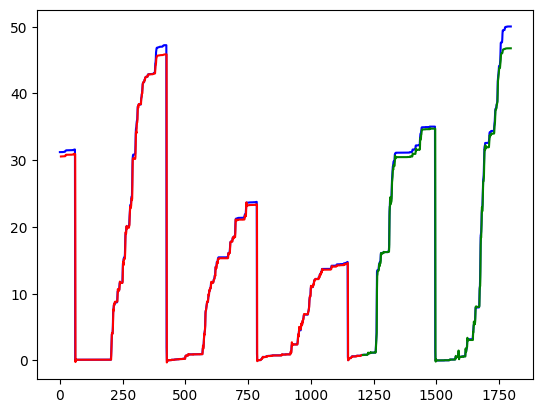

In [99]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

##S&P500

In [7]:
df = pd.read_csv('HistoricalData_1683073126605.csv')

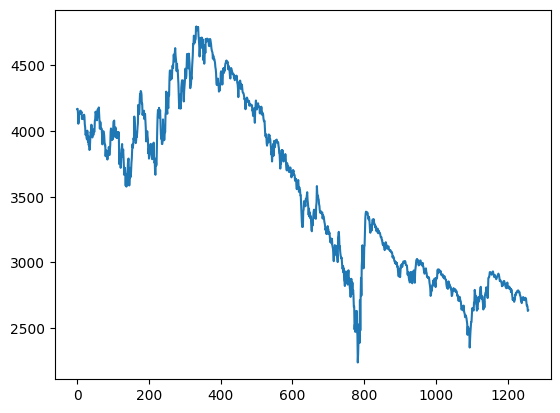

In [8]:
timeseries = df[["Close/Last"]].values.astype('float32')
plt.plot(timeseries)
plt.show()

In [ ]:
def minmax_scale(data, new_min=0, new_max=1):
    old_min = np.min(data)
    old_max = np.max(data)
    
    return (data - old_min) * (new_max - new_min) / (old_max - old_min) + new_min

In [ ]:
normalized_data = minmax_scale(timeseries)

In [38]:
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = normalized_data[:train_size], normalized_data[train_size:]

In [39]:
lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [41]:
class SNP(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=100, num_layers=2, batch_first=True, dropout=0.2)
        self.linear = nn.Linear(100, 1)
        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [42]:
model = SNP()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 1000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 0.1375, test RMSE 0.2268
Epoch 100: train RMSE 0.0209, test RMSE 0.0117
Epoch 200: train RMSE 0.0206, test RMSE 0.0138
Epoch 300: train RMSE 0.0218, test RMSE 0.0189
Epoch 400: train RMSE 0.0214, test RMSE 0.0139
Epoch 500: train RMSE 0.0211, test RMSE 0.0166
Epoch 600: train RMSE 0.0203, test RMSE 0.0123
Epoch 700: train RMSE 0.0207, test RMSE 0.0108
Epoch 800: train RMSE 0.0203, test RMSE 0.0201
Epoch 900: train RMSE 0.0199, test RMSE 0.0122


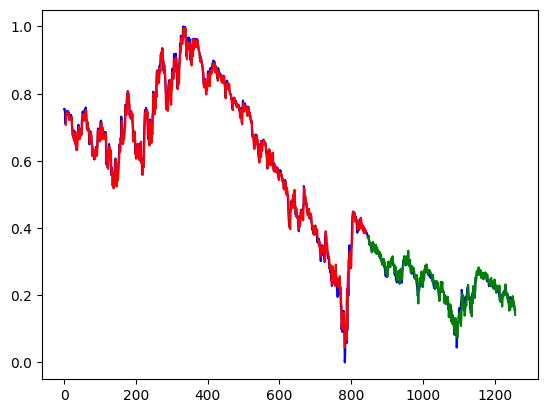

In [43]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(normalized_data) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(normalized_data) * np.nan
    test_plot[train_size+lookback:len(normalized_data)] = model(X_test)[:, -1, :]
# plot
plt.plot(normalized_data, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

In [ ]:
def inverse_minmax_scale(normalized_data, original_min, original_max, new_min=0, new_max=1):
    return (normalized_data - new_min) * (original_max - original_min) / (new_max - new_min) + original_min

# Replace '...' with your normalized data and 'original_min' and 'original_max' with the original min and max values
original_data = inverse_minmax_scale(..., original_min=2500, original_max=5000)